<a href="https://colab.research.google.com/github/rubyvanrooyen/ARIWS-Cookbook/blob/main/2-Flagging_and_calibration/Inspect_and_flagging_calibrators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIWS notebook with sample MeerKAT data using CASA

See the [CASA installation](https://casa.nrao.edu/casadocs/casa-5.6.0/introduction/casa6-installation-and-usage) page for information on the CASA with Jupiter notebooks and Colab
Example code for this notebook can be found on [CASA6_demo.ipynb](https://go.nrao.edu/casa6)

Refer to the [MeerKAT Cookbook](https://github.com/ska-sa/MeerKAT-Cookbook) for information related to archive data access and tokens, as well as the MeerKAT `katdal` software package.

## Upload data
Example data set `ngc3621.ms.tar.gz`

Mount your Google Drive on your runtime using an authorization code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create symbolic link in the /content top layer folder for each processing.
Use the appropriate path to the example dataset you copied to your drive

**NOTE: update the path below to the appropriate directory in drive where you copied the data**

In [2]:
!ln -s "/content/drive/MyDrive/ARIWS public datasets/ngc3621.ms.tar.gz"

Alternatively, you can upload the file directly from your system by adding the commands below to a code cell:
```
from google.colab import files
files.upload()
```

Unpack MeerKAT example data file

In [3]:
import os
rc = os.system("tar -xvzf ngc3621.ms.tar.gz")

## CASA workspace installation


In [ ]:
print("installing pre-requisite packages...")
!apt-get install -y libgfortran3

Google colab upgraded default python for runtime environment to 3.7 in Feb 2021.
At 7 May 2021, no wheel exists for casatools and casatasks installation, using CASA suggested install of pre-release version for 3.7 and 3.8.

Check current python version

In [5]:
!python --version

Python 3.7.10


See if a wheel exist for casatools installation

https://casa.nrao.edu/casa_obtaining.shtml and     
https://casa.nrao.edu/casadocs/latest/usingcasa/obtaining-and-installing

If a wheel exists for this version of python, add the code block as per example (for 3.6)   
```
!pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casaplotms==1.0.24
```

No wheel currently available for 3.7, notes on work around for >=3.7    
https://www.magclouds.org/casa6-docker/html/install/usage.html    
(https://pypi.org/project/casa6-install/)

In [6]:
!git clone https://github.com/r-xue/casa6-docker.git

Cloning into 'casa6-docker'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 316 (delta 136), reused 299 (delta 123), pack-reused 0
Receiving objects: 100% (316/316), 10.21 MiB | 16.13 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [7]:
!ln -s /content/casa6-docker/casa6_install/casa6_install.py casa6_install.py

In [ ]:
!python casa6_install.py

In [9]:
import os

print("building config files...")
!mkdir -p ~/.casa
!echo home, datapath = \'/content/\', [\'/content/\'] > ~/.casa/toolrc.py
!cat ~/.casa/toolrc.py

print('complete')

# check installation
import casatasks
from casatasks import listobs

building config files...
home, datapath = '/content/', ['/content/']
complete
Creating a new telemetry file


Telemetry initialized. Telemetry will send anonymized usage statistics to NRAO.
You can disable telemetry by adding the following line to the config.py file in your rcdir (e.g. ~/.casa/config.py):
telemetry_enabled = False


In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay

print(os.getenv('DISPLAY'))

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

print(os.getenv('DISPLAY'))

## Visualising and inspecting MeerKAT data

In [11]:
from IPython.display import Image
import casaplotms
from casaplotms import plotms
from casatasks import flagdata
from casatasks import listobs

In [12]:
msfile = "ngc3621.ms"
listobs(vis=msfile)
print(os.popen("cat casa-*.log").read())

2021-05-08 17:38:53	INFO	::casa	
2021-05-08 17:38:53	INFO	::casa	CASA Version 6.1.2.7
2021-05-08 17:38:53	INFO	::casa	
2021-05-08 17:38:53	INFO	::casa	Telemetry log file: /root/.casa/casastats-6.1.2.7-242ac1c02-20210508-173853.log
2021-05-08 17:38:53	INFO	::casa	Checking telemetry submission interval
2021-05-08 17:38:53	INFO	::casa	Creating a new telemetry time stamp file./root/.casa/telemetry-242ac1c02.stamp
2021-05-08 17:38:53	INFO	::casa	Telemetry submit interval not reached. Not submitting data.
2021-05-08 17:38:53	INFO	::casa	Next telemetry data submission in: 6 days, 23:59:59.998589
2021-05-08 17:39:37	INFO	listobs::::casa	##########################################
2021-05-08 17:39:37	INFO	listobs::::casa	##### Begin Task: listobs            #####
2021-05-08 17:39:37	INFO	listobs::::casa	listobs( vis='ngc3621.ms', selectdata=True, spw='', field='', antenna='', uvrange='', timerange='', correlation='', scan='', intent='', feed='', array='', observation='', verbose=True, listfile='

To view the CASA log file, double click on the file `casa-*.log` to open for display.    
To refresh the display, double click on the file again.

In [13]:
prefix='ngc3621'
target='NGC3621'
g_cal='1117-248'
b_cal='0408-65'
f_cal='0408-65'

### Apply standard L-band flags

Remove any antennas shadowing each other

In [14]:
flagdata(vis=msfile, mode='shadow');
# if a Leap second warning is raised, simply run the command again to get rid of the warning

Remove bad points that is below minimum pointing angle of observation

In [15]:
flagdata(vis=msfile, mode='elevation', lowerlimit=15., upperlimit=90., action='apply');

Remove extreme outliers

In [16]:
flagdata(vis=msfile, mode='clip', clipminmax = [1e-5, 1000.0]);

Spectral windows are sub-bands. MeerKAT has only one sub-band.
Remove bandpass edges and the Milky Way

In [17]:
flagdata(vis=msfile,
         field='0408-65,1117-248',
         mode='manual',
         spw='*:856~880MHz,*:1658~1800MHz,*:1420.0~1421.3MHz',
         flagbackup=False);

### Check for bad antennas
Flag antennas based on the (mis)behaviour of their autocorrelations.

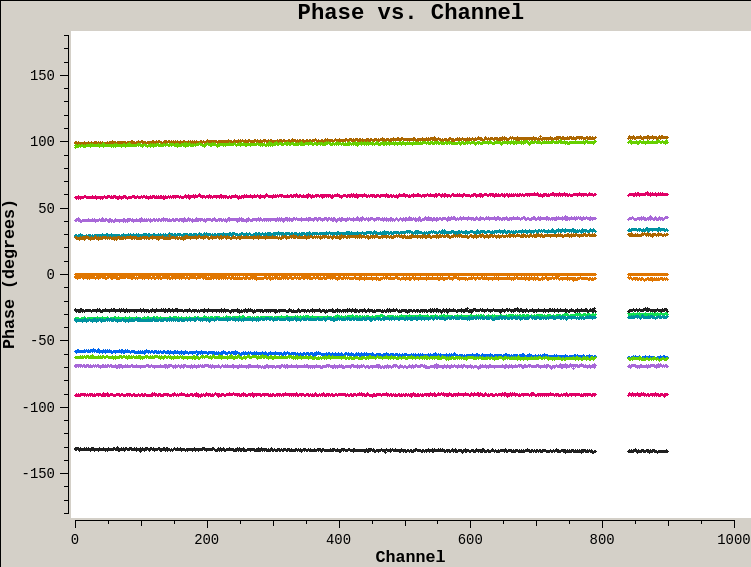

In [18]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       correlation='YY',
       field=f_cal,
       coloraxis='baseline',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

To view the image, double click on the `ngc362_passband.png` file or download the image to your computer.


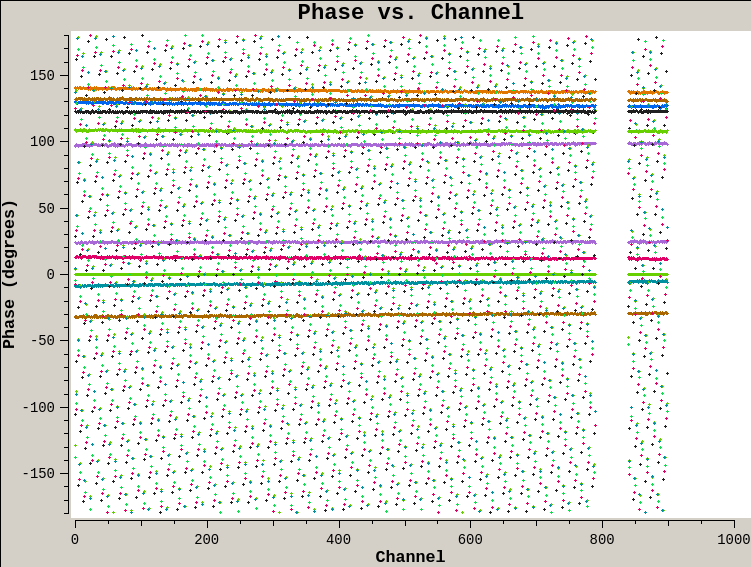

In [19]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       correlation='XX',
       field=f_cal,
       coloraxis='baseline',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

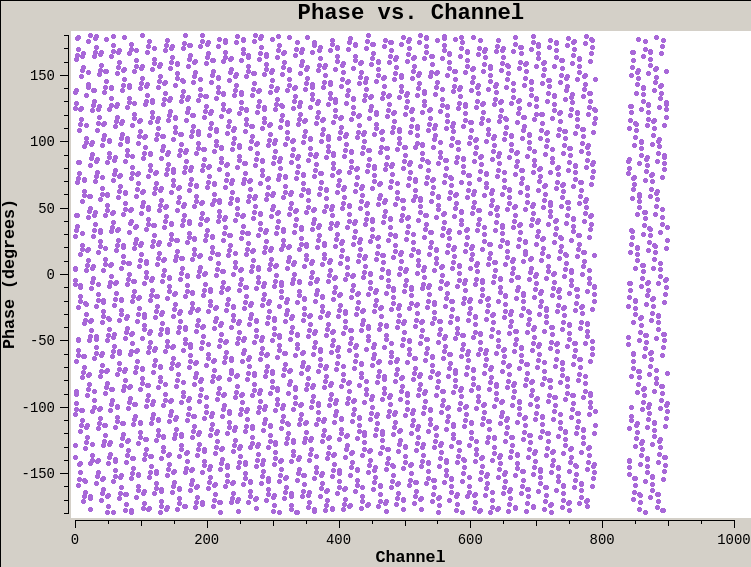

In [20]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       correlation='XX',
       field=f_cal,
       antenna='m022',
       coloraxis='corr',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

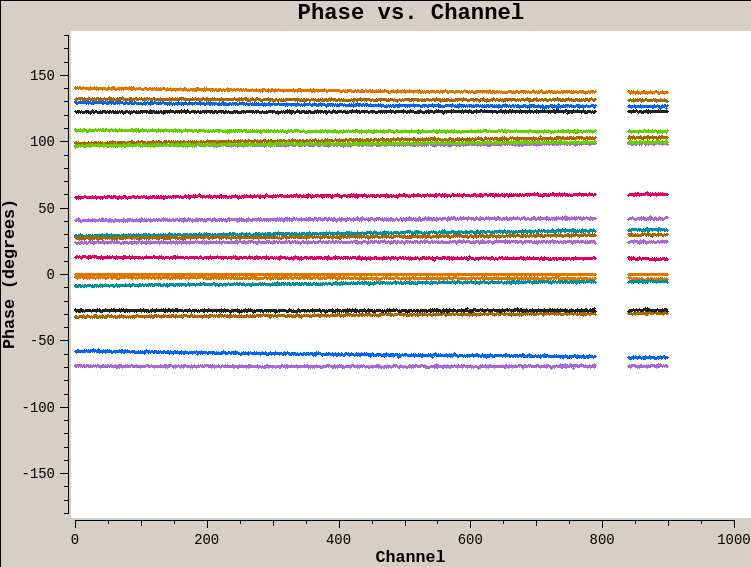

In [21]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       correlation='XX,YY',
       field=f_cal,
       antenna='!m022',
       coloraxis='baseline',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

### Check all the scans of the primary calibrators
Flag based on the autocorrelations.

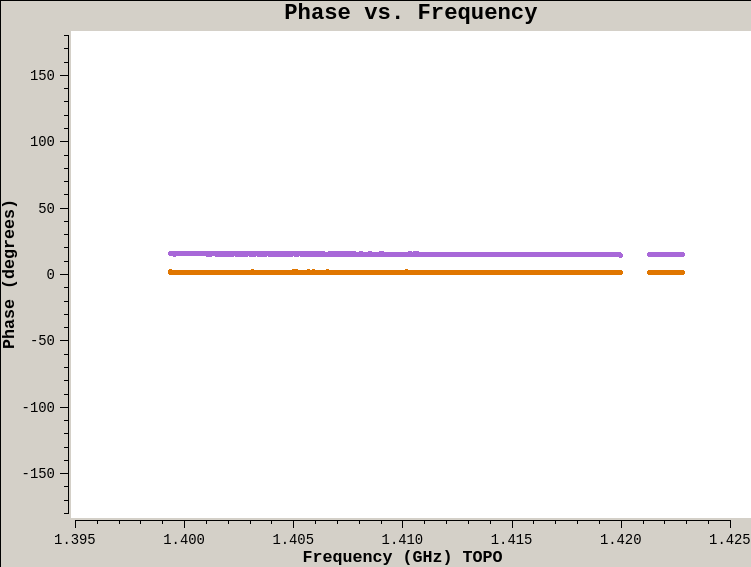

In [22]:
plotms(vis=msfile,
       xaxis='freq',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       avgbaseline=True,
       correlation='XX,YY',
       field=f_cal,
       antenna='!m022',
       scan='1',
       coloraxis='corr',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

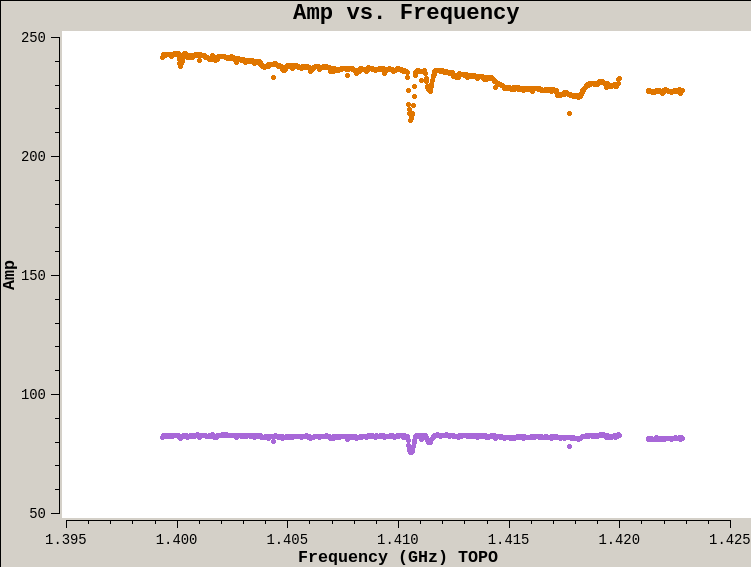

In [23]:
plotms(vis=msfile,
       xaxis='freq',
       yaxis='amp',
       averagedata=True,
       avgtime='3300',
       avgbaseline=True,
       correlation='XX,YY',
       field=f_cal,
       antenna='!m022',
       scan='1',
       coloraxis='corr',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

### Check all the channels and scans for the secondary calibrator

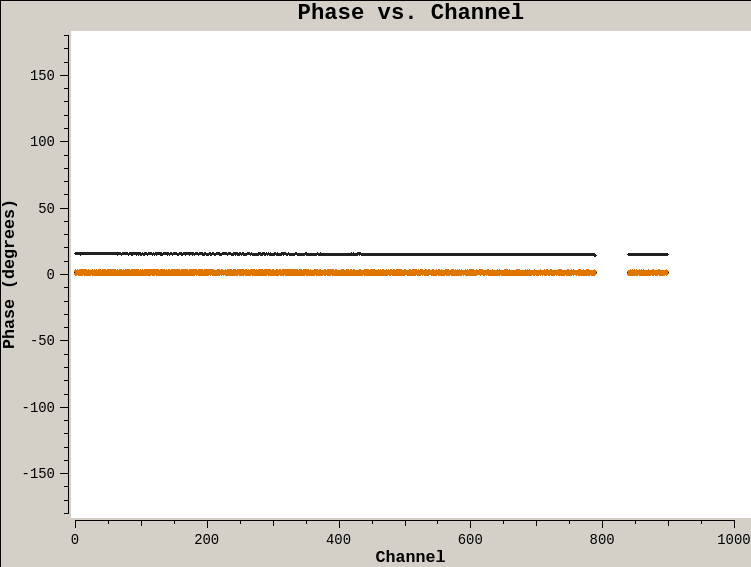

In [24]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       avgbaseline=True,
       correlation='XX,YY',
       field=f_cal+','+g_cal,
       antenna='!m022',
       scan='1,3,5,7,9,11',
       coloraxis='field',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

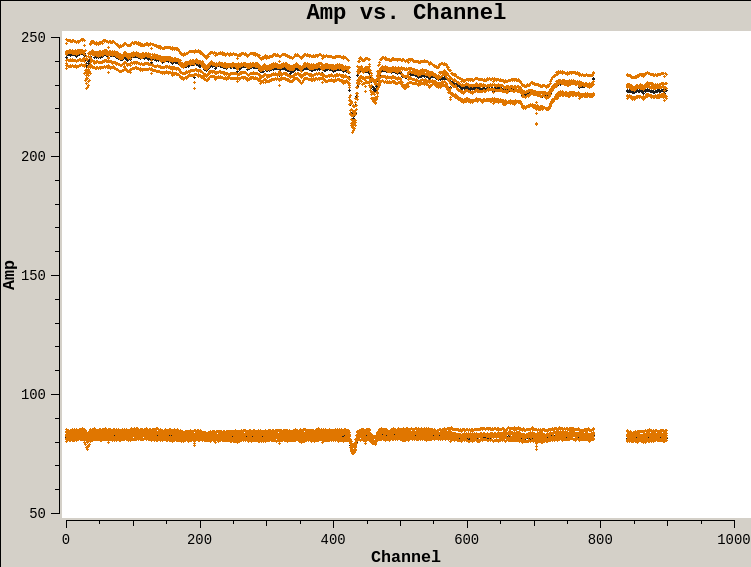

In [25]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='amp',
       averagedata=True,
       avgtime='3300',
       avgbaseline=True,
       correlation='XX,YY',
       field=f_cal+','+g_cal,
       antenna='!m022',
       scan='1,3,5,7,9,11',
       coloraxis='field',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

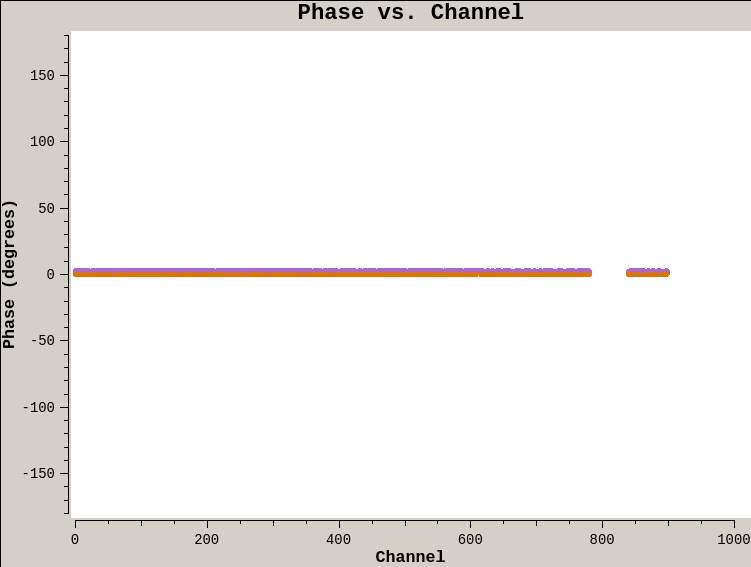

In [26]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       avgbaseline=True,
       correlation='XX,YY',
       field=g_cal,
       antenna='!m022',
       scan='3,5,7,9,11',
       spw='*:0~780;820~900',
       coloraxis='corr',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

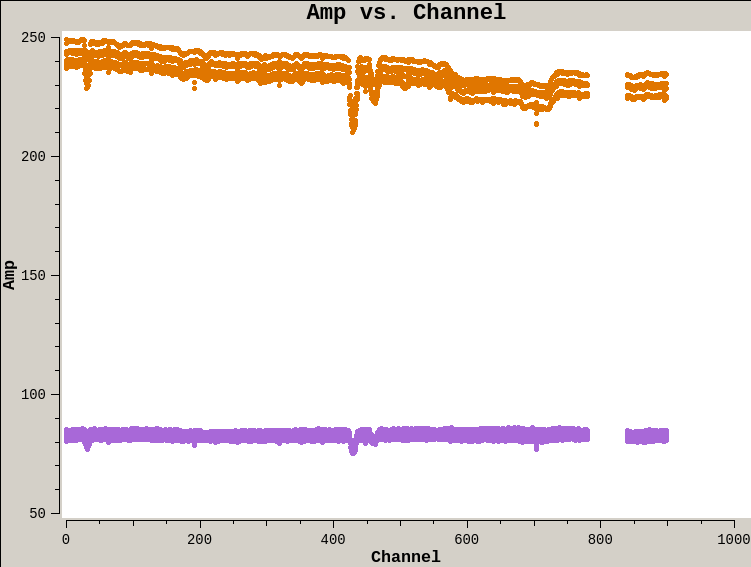

In [27]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='amp',
       averagedata=True,
       avgtime='3300',
       avgbaseline=True,
       correlation='XX,YY',
       field=g_cal,
       antenna='!m022',
       scan='3,5,7,9,11',
       spw='*:0~780;820~900',
       coloraxis='corr',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

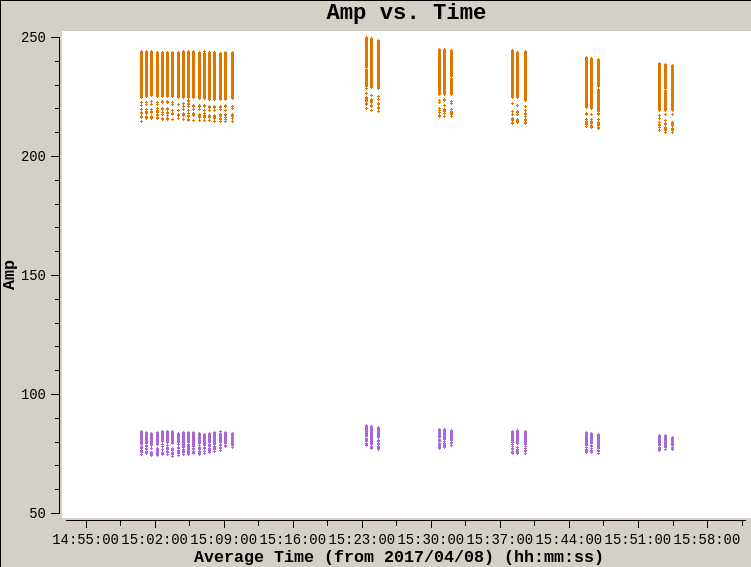

In [28]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='amp',
       averagedata=True,
       avgtime='30',
       avgbaseline=True,
       correlation='XX,YY',
       field=f_cal+','+g_cal,
       antenna='!m022',
       scan='1,3,5,7,9,11',
       spw='*:0~780;820~900',
       coloraxis='corr',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

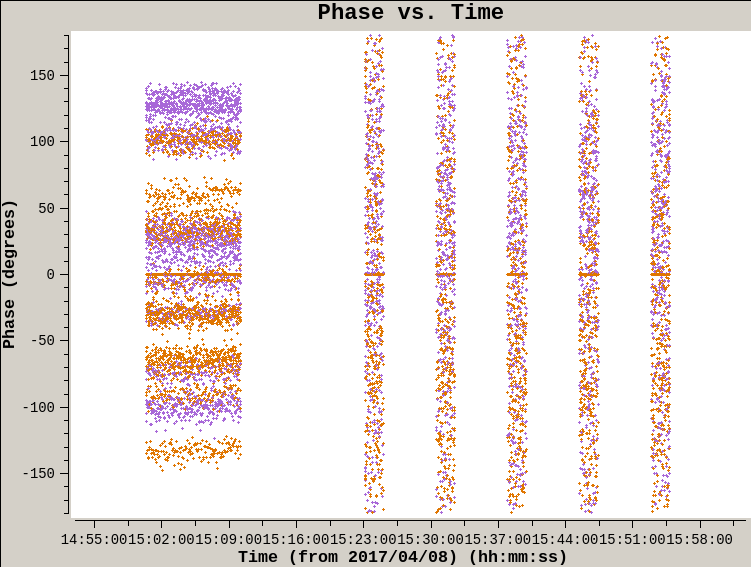

In [29]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='phase',
       correlation='XX,YY',
       field=f_cal+','+g_cal,
       spw='*:2550',
       plotrange=[0,0,-180,180],
       coloraxis='corr',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

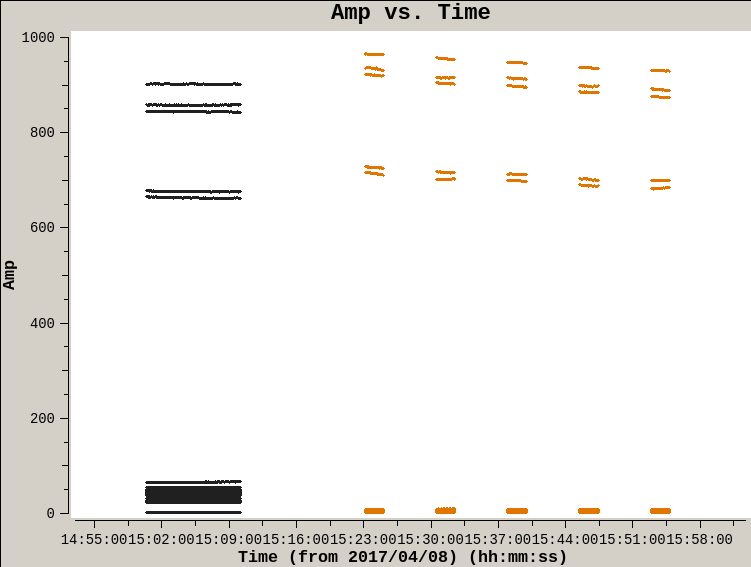

In [30]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='amp',
       field=f_cal+','+g_cal,
       averagedata=True,
       avgchannel='4096',
       coloraxis='field',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

### Flagging data

In [31]:
flagdata(vis=msfile, mode='manual', antenna='m022');

In [32]:
flagdata(vis=msfile, field='0408-65,1117-248', mode='manual', spw='*:30~35', flagbackup=False);
flagdata(vis=msfile, field='0408-65,1117-248', mode='manual', spw='*:420~440', flagbackup=False);
flagdata(vis=msfile, field='0408-65,1117-248', mode='manual', spw='*:450~470', flagbackup=False);
flagdata(vis=msfile, field='0408-65,1117-248', mode='manual', spw='*:790~807', flagbackup=False);

In [33]:
flagdata(vis=msfile, uvrange='<50lambda', flagbackup=False);

### Checking after flagging

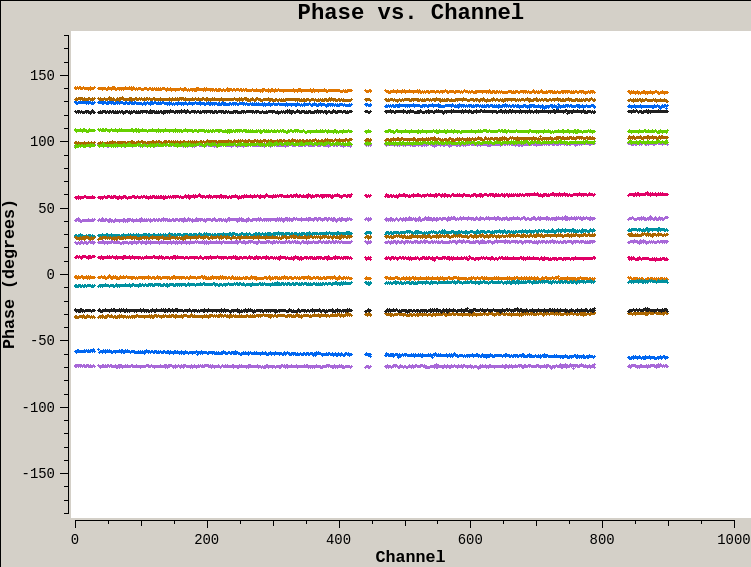

In [34]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='phase',
       averagedata=True,
       avgtime='3300',
       correlation='XX,YY',
       field=f_cal,
       coloraxis='baseline',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

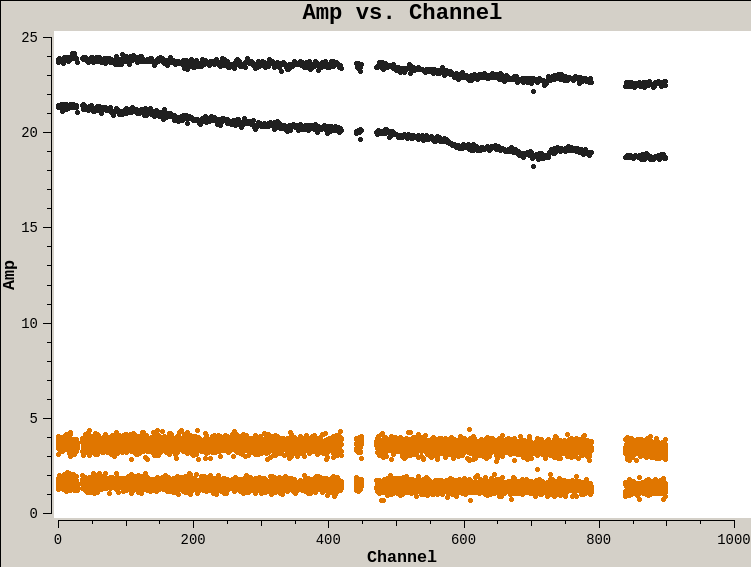

In [35]:
plotms(vis=msfile,
       xaxis='channel',
       yaxis='amp',
       averagedata=True,
       avgtime='3300',
       avgbaseline=True,
       correlation='XX,YY',
       field=f_cal+','+g_cal,
       coloraxis='field',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

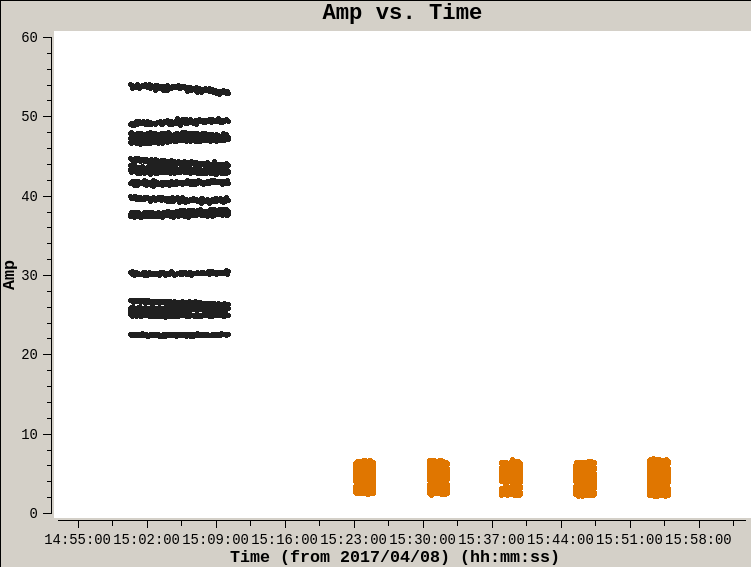

In [36]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='amp',
       averagedata=True,
       avgchannel='4096',
       correlation='XX,YY',
       field=f_cal+','+g_cal,
       coloraxis='field',
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

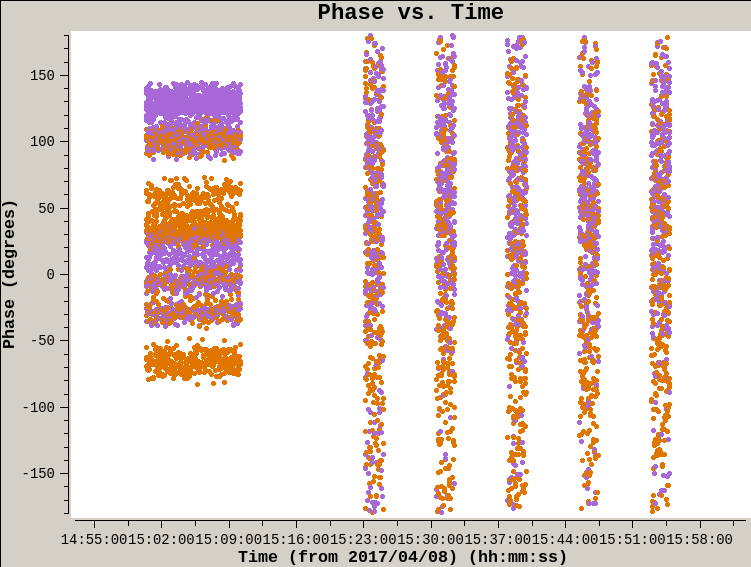

In [37]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='phase',
       correlation='XX,YY',
       field=f_cal+','+g_cal,
       spw='*:2550',
       coloraxis='corr',
       plotrange=[0,0,-180,180],
       showgui=False,
       plotfile='ngc362_passband.png',
       overwrite=True,
       )
Image('ngc362_passband.png', height=500)

## Copy flagged data back to Google drive

In [ ]:
!tar -cvzf "ngc3621_flagged.ms.tar.gz" "ngc3621.ms"

In [ ]:
!tar -tvzf "ngc3621_flagged.ms.tar.gz"

**NOTE: update the path below to the appropriate directory in drive where you want to save the data**

In [42]:
!cp "ngc3621_flagged.ms.tar.gz" "drive/MyDrive/ARIWS public datasets/output"